In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import feather
import numpy as np
import pandas as pd
import scipy.io as sio
from data_funcs import reorder_ps_TE,extract_arrays,TEM_dataset, TEM_rem_lowsampled_classes

#Parameters
#beta_threshold controls number of genes that remain in the final list (Jeremy: use 0.2-0.4) 
#BetaScore is a measure of differential expression for each gene.
beta_threshold = 0.4

#T files: /allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse_patchseq_VISp_20191113_collapsed40_cpm/
#E files: /allen/programs/celltypes/workgroups/ivscc/nathang/spca_output/sparse_pca_components_mMET_curated_Nov11.csv
#M files: /allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Nov11_ccf_soma_locations.csv
pth={}

base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
pth['ref_colors']       = base_path + 'type_color_reference.csv' #Generated for inhibitory types from the FACS annotations
pth['ps_T_dat']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_data.feather'
pth['ps_T_ann']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_anno.feather'
pth['ps_E_dat']         = base_path + 'sparse_pca_components_mMET_curated_Nov11.csv'
pth['ps_M_dat']         = base_path + 'mouse_met_Nov11_ccf_soma_locations.csv'
pth['jeremy_gene_set']  = base_path + 'good_genes_beta_score.csv'
pth['QC_cells']         = base_path + 'specimen_ids_for_paper_Nov_2019.txt'
pth['save']             = base_path

In [4]:
#Load reference colors
ref = pd.read_csv(pth['ref_colors'])

In [5]:
#Load patchseq T data and annotations
orig_dat = feather.read_dataframe(pth['ps_T_dat'])
orig_ann = feather.read_dataframe(pth['ps_T_ann'])

In [6]:
keep_cell_id = pd.read_csv(pth['QC_cells'],header=None,names=['spec_id'])
keep_gene_id = pd.read_csv(pth['jeremy_gene_set'])
keep_gene_id = keep_gene_id[keep_gene_id.BetaScore>beta_threshold]['Gene'].to_list()

In [7]:
#Restrict T data based on genes:
keepcols = ['sample_id'] + keep_gene_id
orig_dat = orig_dat[keepcols]

In [8]:
#Restrict cells to good quality cells if a cell list provided:
if keep_cell_id is not None:
    #Only core and I1 cells:
    cond1 = orig_ann['Tree_call_label'].isin(['Core','I1'])
    cond2 = orig_ann['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
    cond3 = orig_ann['subclass_label'].isin(['Sst','Pvalb','Vip','Lamp5','Sncg','Serpinf1'])
    ps_T_ann = orig_ann[cond1 & cond2 & cond3].reset_index(drop=True)
    ps_T_dat = orig_dat[cond1 & cond2 & cond3].reset_index(drop=True)
    assert np.array_equal(ps_T_dat['sample_id'].values,ps_T_ann['sample_id'].values),'T data and annotations are mismatched'

In [9]:
#cluster_labels are now called topLeaf_label. Colors are determined from the facs reference:
ps_T_ann['cluster_label'] = ps_T_ann['topLeaf_label'].values
ps_T_ann['cluster_id'] = ps_T_ann['topLeaf_id'].values

#Delete the color annotations in the patchseq file, and replace with FACS reference colors
del ps_T_ann['cluster_color']
ps_T_ann = ps_T_ann.join(ref.set_index('celltype'),on='cluster_label') 

In [10]:
#Load E data
orig_E_dat = pd.read_csv(pth['ps_E_dat'])
orig_E_dat.rename(columns = {orig_E_dat.columns[0]: 'spec_id_label'}, inplace=True)
cond1 = orig_E_dat['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
ps_E_dat = orig_E_dat[cond1]

In [11]:
ps_Tcat_dat, ps_Tcat_ann, ps_Ecat_dat, ispairedT, ispairedE = reorder_ps_TE(ps_T_dat,ps_T_ann,ps_E_dat)
matdict = extract_arrays(ps_Tcat_dat, ps_Tcat_ann, ispairedT, ps_Ecat_dat, ispairedE, keep_gene_id)

-----------------------------------------------
0 exclusive, 2745 matched, total 2745 in T
-----------------------------------------------
963 exclusive, 2745 matched, total 3708 in E


**Add `M` data to `matdict`**: 
 - At this point, `matdict` contains the matched `T` and `E` data. 
 - `M` data is available for all but 6 cells that are present in `E`
 - Check the `T` labels for the cells that are missing in `M`
 

In [12]:
#Read soma depth for each cell and perform checks:
orig_M_dat = pd.read_csv(pth['ps_M_dat'])
orig_M_dat = orig_M_dat[['specimen_id','ccf_depth']]
print('{:d} cells without depth information'.format(orig_M_dat['ccf_depth'].isna().sum()))
print('--------------------------------------\n')

ind = orig_M_dat['ccf_depth'].isna()
#5 out of the 6 cells are in Core and I1. All 5 types are well sampled.
ind = np.isin(ps_T_ann['spec_id_label'].values.astype(int),orig_M_dat['specimen_id'][ind])
no_depth_ann = ps_T_ann[['Tree_call_label','spec_id_label','topLeaf_label']][ind]
print(no_depth_ann)
print('--------------------------------------\n')

X = ps_Tcat_ann['topLeaf_label'].value_counts().to_frame()
for celltype in no_depth_ann['topLeaf_label'].values:
    print('{:20s}: {:d}'.format(celltype,X.loc[celltype]['topLeaf_label']))

6 cells without depth information
--------------------------------------

     Tree_call_label spec_id_label       topLeaf_label
1030            Core     850845099    Sst Calb2 Pdlim5
1440            Core     808547132    Sst Crhr2 Efemp1
1810            Core     715106551             Sst Nts
1876              I1     724790111     Pvalb Calb1 Sst
1884            Core     830467557  Pvalb Akr1c18 Ntf3
--------------------------------------

Sst Calb2 Pdlim5    : 192
Sst Crhr2 Efemp1    : 94
Sst Nts             : 34
Pvalb Calb1 Sst     : 18
Pvalb Akr1c18 Ntf3  : 42


In [13]:
#Fill nans for the cells that 
ind = np.empty((orig_M_dat['specimen_id'].values.size,),dtype=int)
matdict['M_dat'] = np.empty((orig_M_dat['specimen_id'].values.size,),dtype=np.float32)
matdict['M_dat'].fill(np.nan)
for i,spec_id in enumerate(orig_M_dat['specimen_id'].values):
    ind[i] = np.flatnonzero(matdict['E_spec_id_label']==int(spec_id))
    matdict['M_dat'][ind[i]] = orig_M_dat['ccf_depth'].values[i]

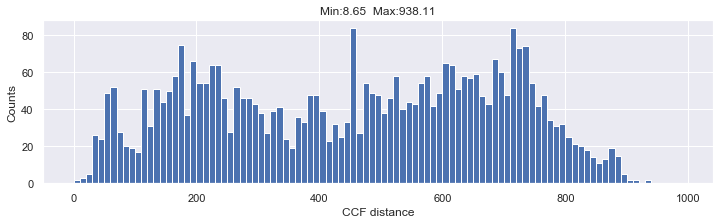

In [14]:
ind = ~np.isnan(matdict['M_dat'])
print()
plt.figure(figsize=(12,3))
plt.hist(matdict['M_dat'][ind],np.arange(0,1000,10))
ax = plt.gca()
ax.set_title('Min:{:0.2f}  Max:{:0.2f}'.format(np.min(matdict['M_dat'][ind]),
                                       np.max(matdict['M_dat'][ind])))
ax.set_xlabel('CCF distance')
ax.set_ylabel('Counts')
plt.show()

**Normalizing M data**

Mean: 454.49,  SD: 232.72


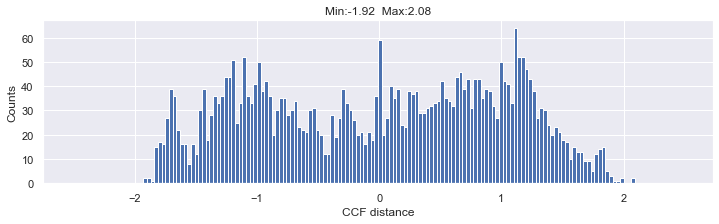

In [15]:
norm_M_data = matdict['M_dat'].copy()
M_mean = np.nanmean(matdict['M_dat'])
M_sd   = np.nanstd(matdict['M_dat'])
print('Mean: {:0.2f},  SD: {:0.2f}'.format(M_mean,M_sd))
norm_M_data = (norm_M_data-M_mean)/M_sd
matdict['M_dat'] = norm_M_data

plt.figure(figsize=(12,3))
plt.hist(matdict['M_dat'][ind],np.arange(-2.5,2.5,0.03))
ax = plt.gca()
ax.set_title('Min:{:0.2f}  Max:{:0.2f}'.format(np.min(matdict['M_dat'][ind]),
                                       np.max(matdict['M_dat'][ind])))
ax.set_xlabel('CCF distance')
ax.set_ylabel('Counts')
plt.show()

**Counts of sampled transcriptomic types**

In [16]:
X = ps_Tcat_ann['cluster_label'].value_counts().to_frame()
X.rename(columns={'cluster_label': 'counts'},inplace=True)
Y = ps_Tcat_ann[['cluster_id','cluster_label','cluster_color']].drop_duplicates().sort_values(by='cluster_label').reset_index(drop=True)
X = Y.set_index('cluster_label').join(X).reset_index()

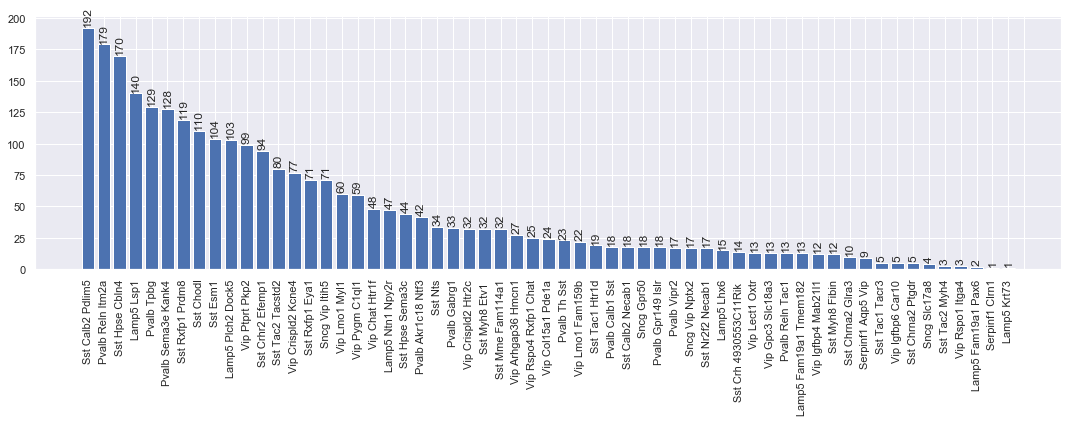

In [17]:
X = X.sort_values(by='counts',ascending=False).reset_index()
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color='b')
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/v4_histogram_sorted.png',dpi=300)

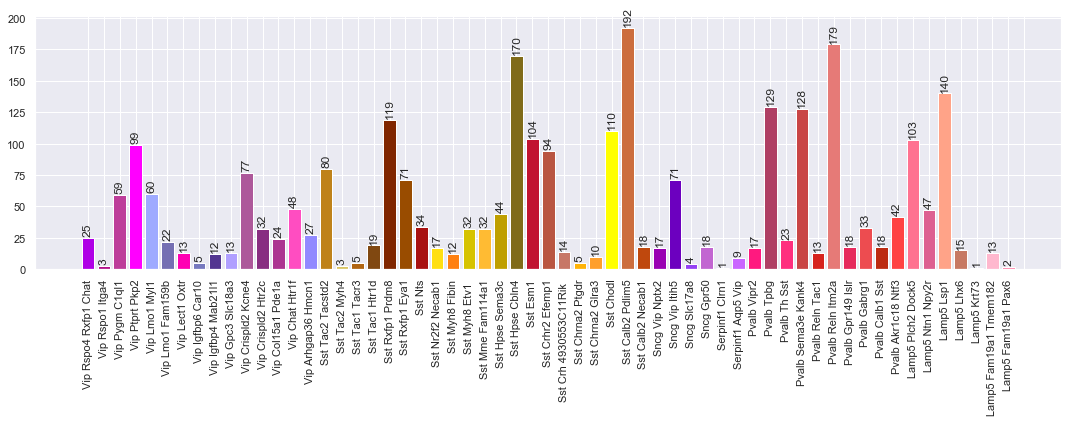

In [18]:
X = X.sort_values(by='cluster_id',ascending=False).reset_index()
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color=X['cluster_color'].values[i])
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/v4_histogram.png',dpi=300)

**Electrophysiology feature-wise distributions**

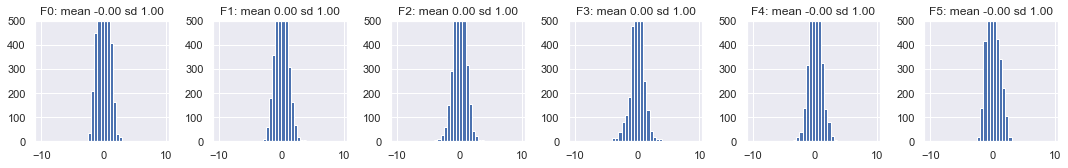

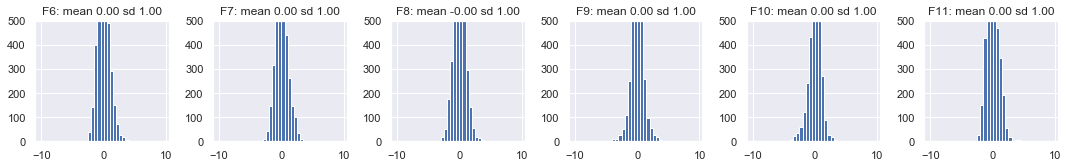

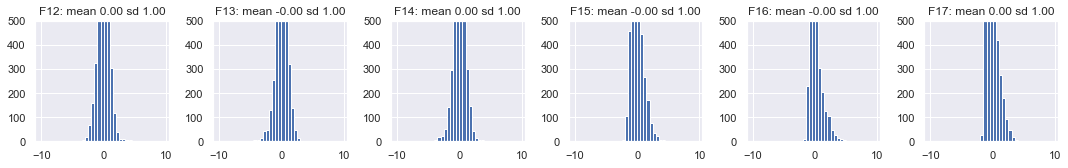

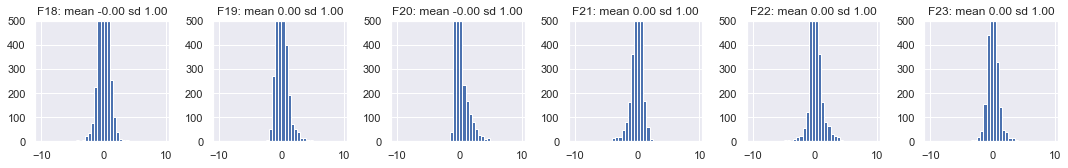

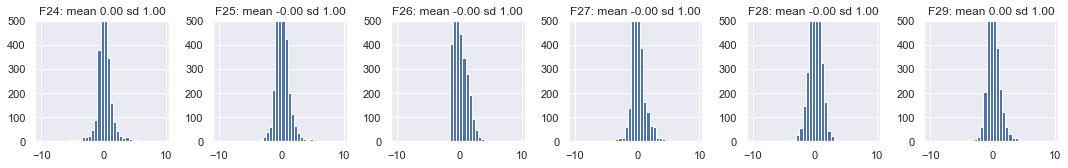

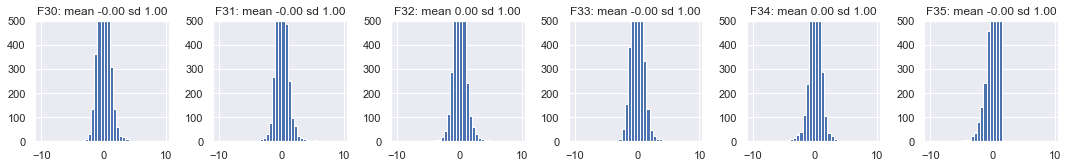

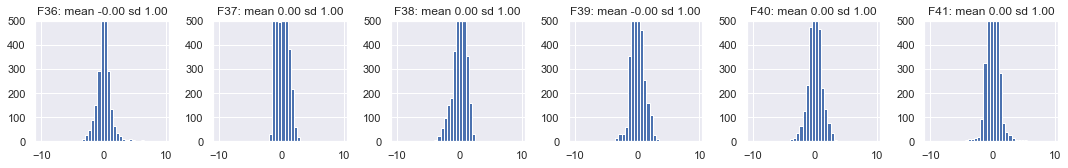

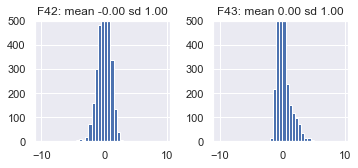

In [19]:
matdict['E_dat'].shape
nplots_perline = 6
for i in range(matdict['E_dat'].shape[1]):
    if i%nplots_perline==0:
        plt.figure(figsize = (15,2.5))
    plt.subplot(1,nplots_perline,i%nplots_perline+1)
    ax = plt.gca()
    ax.set_title('F{:d}: mean {:.2f} sd {:.2f}'.format(i,np.mean(matdict['E_dat'][:,i]),np.std(matdict['E_dat'][:,i])))
    ax.set_ylim(0,500)
    counts=plt.hist(matdict['E_dat'][:,i],np.arange(-10,10,0.5))
    bins = counts[1]
    bins = (bins[0:-1]+bins[1:])/2
    counts = counts[0]

    #for j in range(bins.size):
    #    plt.text(bins[j],counts[j],str(counts[j]),rotation = 90,horizontalalignment='center')
    plt.tight_layout()

**Inspect and remove outliers**

In [20]:
all_outliers = np.zeros((matdict['E_dat'].shape[0],), dtype=bool)
for i in range(matdict['E_dat'].shape[1]):
    outlier_ind = np.abs(matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i]))>6*np.std(matdict['E_dat'][:,i])
    outliers = np.sum(outlier_ind)
    if outliers>0:
        print('{:d} outliers in feature {:d}'.format(outliers,i))
    all_outliers = np.logical_or(all_outliers,outlier_ind)

print('\n')
outlier_inds = np.flatnonzero(all_outliers)
paired_outlier_inds = outlier_inds[matdict['E_ispaired'][outlier_inds]==1]
print(pd.Series(np.sort(matdict['cluster'][paired_outlier_inds])).value_counts())

1 outliers in feature 10
2 outliers in feature 12
1 outliers in feature 16
8 outliers in feature 18
3 outliers in feature 19
3 outliers in feature 20
4 outliers in feature 21
6 outliers in feature 22
2 outliers in feature 23
9 outliers in feature 24
1 outliers in feature 25
1 outliers in feature 26
3 outliers in feature 27
4 outliers in feature 29
4 outliers in feature 31
3 outliers in feature 34
2 outliers in feature 35
15 outliers in feature 36
1 outliers in feature 41


Vip Crispld2 Kcne4    4
Lamp5 Plch2 Dock5     3
Pvalb Sema3e Kank4    3
Vip Crispld2 Htr2c    2
Pvalb Gabrg1          2
Pvalb Reln Itm2a      2
Sst Hpse Cbln4        2
Vip Ptprt Pkp2        2
Sst Chrna2 Glra3      2
Vip Arhgap36 Hmcn1    2
Sst Chodl             2
Vip Igfbp4 Mab21l1    1
Sst Tac2 Tacstd2      1
Vip Rspo1 Itga4       1
Sst Calb2 Pdlim5      1
Lamp5 Ntn1 Npy2r      1
Sst Hpse Sema3c       1
Sst Crhr2 Efemp1      1
Sst Myh8 Fibin        1
Vip Lmo1 Myl1         1
Sncg Gpr50            1
Sst Chrna2 Ptgdr  

**Removing Ephys feature outliers**

Outliers are detected on a per feature basis.

In [21]:
for i in range(matdict['E_dat'].shape[1]):
    condition = 6*np.std(matdict['E_dat'][:,i])
    outlier_max_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) > condition
    outlier_min_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) < -1.0*condition

    matdict['E_dat'][outlier_max_ind,i]=condition
    matdict['E_dat'][outlier_max_ind,i]=-1.0*condition

In [22]:
TEM_matdict = TEM_dataset(matdict=matdict)

6 M datapoints have nans
2740 remaining samples
59 remaining T-types 


**Remove poorly sampled classes and create test data**

In [23]:
TEM_matdict_well_sampled = TEM_rem_lowsampled_classes(TEM_matdict.copy(),count_threshold=10)

Keeping 2702 out of 2740 cells
2702 remaining samples
49 remaining T-types 


**Save matrices**

In [24]:
sio.savemat(pth['save']+'PS_v4_beta_0-4_matched_well-sampled.mat',TEM_matdict_well_sampled)
sio.savemat(pth['save']+'PS_v4_beta_0-4_matched.mat',TEM_matdict)
sio.savemat(pth['save']+'PS_v4_beta_0-4_all.mat',matdict)

**Save copy with ephys data columns names**

In [24]:
#Borrowing code from Nathan's notebook to rename ephys columns
import json
with open(base_path+"/spca_components_used_mMET_curated_Nov11.json") as f:
    new_comp_info = json.load(f)
new_col_lookup = {}
counter = 0
for ci in new_comp_info:
    new_col_lookup[ci["key"]] = [str(counter + i) for i, v in enumerate(ci["indices"])]
    counter += len(ci["indices"])

keys_=[]
columns_=[]
for key,value in new_col_lookup.items():
    for i,v in enumerate(value):
        keys_.append(key+'_'+str(i))
        columns_.append(v)
keys_ = np.array(keys_)
columns_ = np.array([int(c) for c in columns_])

sort_ind = np.argsort(columns_)
keys_ = keys_[sort_ind]
columns_ = columns_[sort_ind]

In [25]:
import pprint
pprint.pprint(list(zip(columns_,keys_)))

[(0, 'first_ap_v_0'),
 (1, 'first_ap_v_1'),
 (2, 'first_ap_v_2'),
 (3, 'first_ap_v_3'),
 (4, 'first_ap_v_4'),
 (5, 'first_ap_dv_0'),
 (6, 'first_ap_dv_1'),
 (7, 'first_ap_dv_2'),
 (8, 'first_ap_dv_3'),
 (9, 'first_ap_dv_4'),
 (10, 'first_ap_dv_5'),
 (11, 'isi_shape_0'),
 (12, 'isi_shape_1'),
 (13, 'isi_shape_2'),
 (14, 'step_subthresh_0'),
 (15, 'step_subthresh_1'),
 (16, 'subthresh_norm_0'),
 (17, 'subthresh_norm_1'),
 (18, 'subthresh_norm_2'),
 (19, 'subthresh_norm_3'),
 (20, 'inst_freq_0'),
 (21, 'inst_freq_1'),
 (22, 'inst_freq_2'),
 (23, 'inst_freq_3'),
 (24, 'inst_freq_4'),
 (25, 'inst_freq_5'),
 (26, 'spiking_upstroke_downstroke_ratio_0'),
 (27, 'spiking_upstroke_downstroke_ratio_1'),
 (28, 'spiking_peak_v_0'),
 (29, 'spiking_peak_v_1'),
 (30, 'spiking_fast_trough_v_0'),
 (31, 'spiking_fast_trough_v_1'),
 (32, 'spiking_threshold_v_0'),
 (33, 'spiking_threshold_v_1'),
 (34, 'spiking_threshold_v_2'),
 (35, 'spiking_width_0'),
 (36, 'spiking_width_1'),
 (37, 'inst_freq_norm_0'),
 (

In [26]:
ps_E_dat.rename(columns = {ps_E_dat.columns[0]: 'spec_id_label'}, inplace=True)
for i in range(1,ps_E_dat.shape[1],1):
    ps_E_dat.rename(columns = {ps_E_dat.columns[i]: keys_[i-1]}, inplace=True)

ps_E_dat.to_csv(base_path + 'sparse_pca_components_mMET_curated_Nov11_withheaders.csv',index=False)

**Load raw time series traces for the cells included in curated set:**

Not performed for the latest dataset.

In [ ]:
ps_E_dat = pd.read_csv(base_path + 'sparse_pca_components_mMET_curated_Nov11_withheaders.csv')

In [ ]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

dat = {}
with h5py.File(base_path + 'fv_mMET_curated_Jun14.h5', 'r') as f:
    dat['spiking_width'] = f['spiking_width'][...]
    dat['spiking_peak_v'] = f['spiking_peak_v'][...]
    dat['spiking_upstroke_downstroke_ratio'] = f['spiking_upstroke_downstroke_ratio'][...]
    dat['subthresh_norm'] = f['subthresh_norm'][...]
    dat['first_ap_v'] = f['first_ap_v'][...]
    dat['psth'] = f['psth'][...]
    dat['ids'] = f['ids'][...]
    
keep = np.nonzero(np.isin(dat['ids'],ps_E_dat['spec_id_label'].values))[0]
dat['ids'] = dat['ids'][keep]
dat['psth'] = dat['psth'][keep]
dat['spiking_width'] = dat['spiking_width'][keep]
dat['spiking_peak_v'] = dat['spiking_peak_v'][keep]
dat['spiking_upstroke_downstroke_ratio'] = dat['spiking_upstroke_downstroke_ratio'][keep]
dat['subthresh_norm'] = dat['subthresh_norm'][keep]
dat['first_ap_v'] = dat['first_ap_v'][keep]

In [ ]:
for key,val in dat.items():
    print(key,val.shape)

In [ ]:
cell_ind=np.array(np.arange(0,5,1))
for key,val in dat.items():
    if key != 'ids':
        plt.figure(figsize=(5,5))
        for i in cell_ind:
            plt.plot(val[i,:])
        ax = plt.gca()
        ax.set_title(key)

In [ ]:
import scipy.io as sio
D = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/Mouse-V1-ALM-20180520_cpmtop10k_cpm.mat',squeeze_me=True)
col = D['cluster_color'][0:20000]
X = D['log1p'][:,0:5000]
X = X[0:20000,:]
plot_ind = np.linspace(0,19999,1000,dtype=np.int32)

In [ ]:
#Used to generate reference color file:
D = sio.loadmat('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/Mouse-V1-ALM-20180520_cpmtop10k_cpm.mat',squeeze_me=True)
ctype_list = []
col_list = []
for ctype,col in list(set(zip(D['cluster'],D['cluster_color']))):
    ctype_list.append(ctype)
    col_list.append(col)
D = pd.DataFrame({'celltype':ctype_list,'cluster_color':col_list})
D = D.loc[D['celltype'].isin(np.unique(ps_Tcat_ann['topLeaf_label'].values))]
D = D.reset_index(drop=True)
D.to_csv(base_path + 'type_color_reference.csv',index=False)

**ME cluster assignments**

In [45]:
import scipy.io as sio
import pandas as pd

dir_pth = {}
#/allen/programs/celltypes/workgroups/ivscc/nathang/me_clust_output/inh_met_mouse_me_clustering/refined_text_labels.csv
dir_pth['data'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
O = sio.loadmat(dir_pth['data']+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
ME = pd.read_csv(dir_pth['data']+'refined_text_labels.csv')
ME.columns = ['spec_id_label','cluster']
MEdict = {'spec_id_label':ME['spec_id_label'].values,'cluster':ME['cluster'].values}

ind = np.isin(O['E_spec_id_label'],MEdict['spec_id_label'])
print('{:d} cells have ME labels'.format(np.sum(ind)))
O['ME_cluster'] = np.array(['NA']*np.size(O['E_spec_id_label']),dtype='object')
for e in O['E_spec_id_label']:
    set_ind = (MEdict['spec_id_label']==e)
    if np.sum(set_ind)==1:
        O['ME_cluster'][O['E_spec_id_label']==e] = MEdict['cluster'][set_ind]

335 cells have ME labels


me = pd.DataFrame({'cluster':O['ME_cluster']})
X = me['cluster'].value_counts().to_frame()

In [49]:
me = pd.DataFrame({'cluster':O['ME_cluster']})
X = me['cluster'].value_counts().to_frame()

In [50]:
X

,cluster
NA,2367
mMET_ME_9,29
mMET_ME_21,23
mMET_ME_5,20
mMET_ME_8,20
mMET_ME_17,19
mMET_ME_1,18
mMET_ME_11,18
mMET_ME_2,16
mMET_ME_3,15


In [38]:
X.rename(columns={'cluster': 'counts'},inplace=True)

#for c in O['ME_cluster']:
X = X.sort_values(by='counts',ascending=False).reset_index()
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color='b')
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster'].values, rotation=90)
plt.tight_layout()
plt.show()

335 cells have ME labels


**FACS datasets**

In [1]:
import pandas as pd
import scipy.io as sio
import feather
import seaborn as sns

In [2]:
mount_pth = '/home/rohan/Remote-AI-root'
pth = {}
pth['facs_dat_20180520'] = mount_pth + '/data/rnaseqanalysis/shiny/facs_seq/mouse_V1_ALM_20180520/data.feather'
pth['facs_ann_20180520'] = mount_pth + '/data/rnaseqanalysis/shiny/facs_seq/mouse_V1_ALM_20180520/anno.feather'
pth['save']              = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/'

In [3]:
facs_dat = feather.read_dataframe(pth['facs_dat_20180520'])
facs_ann = feather.read_dataframe(pth['facs_ann_20180520'])

In [4]:
facs_gene_ids = facs_dat.columns[1:].values

In [5]:
pth['patchseq'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
O = sio.loadmat(pth['patchseq']+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
Otemp = sio.loadmat(pth['patchseq']+'PS_v4_beta_0-4_all.mat',squeeze_me=True)
patchseq_gene_ids=Otemp['gene_id']
del Otemp

In [6]:
assert np.sum(np.isin(facs_gene_ids,patchseq_gene_ids))==patchseq_gene_ids.size, 'Some genes are missing'

In [7]:
#Restrict to patchseq genes:
facs_dat = facs_dat[patchseq_gene_ids]

In [8]:
matdict={}
matdict['log1p']         = np.log1p(facs_dat.values.astype('float32'))
matdict['gene_id']       = facs_dat.columns.values
matdict['cluster']       = facs_ann.loc[:,'cluster_label'].values
matdict['clusterID']     = facs_ann.loc[:,'cluster_id'].values.astype(int)
matdict['cluster_color'] = facs_ann.loc[:,'cluster_color'].values
matdict['sample_id']     = facs_ann.loc[:,'sample_id'].values

In [9]:
patchseq_ttypes = np.unique(O['cluster'])

In [10]:
#Restrict to cells belonging to t-types in the patchseq dataset
keep_cells = np.isin(matdict['cluster'],patchseq_ttypes)
print('{:d} cells belong to t-types retained in the patchseq dataset'.format(np.sum(keep_cells)))

matdict['log1p'] = matdict['log1p'][keep_cells,:]
for fld in ['cluster','clusterID','cluster_color','sample_id']:
    matdict[fld] = matdict[fld][keep_cells]

sio.savemat(pth['save']+'Mouse-V1-ALM-20180520_GABA_patchseq_v1.mat',matdict)

9343 cells belong to t-types retained in the patchseq dataset


In [11]:
#Get sorted positions and colors for ttypes according to patchseq dataset
from analysis_tree_helpers import HTree, Node, get_valid_classifications
import scipy.io as sio
import pandas as pd

simple_tree_filename = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)
(lbl,count) = np.unique(O['cluster'],return_counts=True)
x=[]
y=[]
col=[]
for l in lbl:
    x.append(htree.x[htree.child==l])
    y.append(count[lbl==l])
    col.append(htree.col[htree.child==l])
x = np.array(x).flatten()
y = np.array(y).flatten()
col = np.array(col).flatten()    
ind = np.argsort(x)
xsort = np.empty(x.shape)
xtemp = np.arange(x.size)*60/x.size
xsort[ind] = xtemp

Y = list(zip(lbl,col,xsort))
xarr = [y[2] for y in Y]

**FACS distribution**

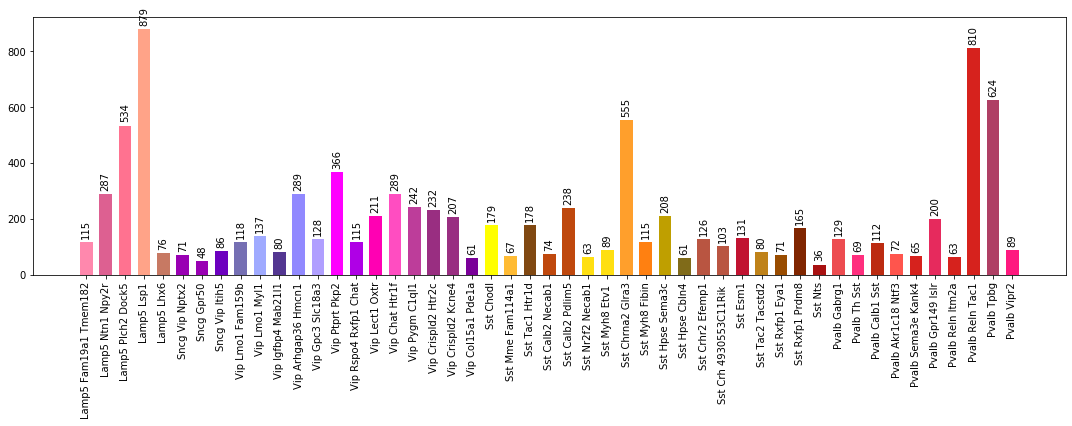

In [12]:
i = 0 
fig = plt.figure(figsize = (15,6))
ttype_list = []
for (ttype,col,xsort) in Y:
    ttype_list.append(ttype)
    counts = np.sum(matdict['cluster']==ttype)
    plt.bar(x=xsort,height=counts,color=col)
    plt.text(xsort,counts+20,str(counts),rotation = 90,horizontalalignment='center')
    i = i+1
ax = plt.gca()           
ax.set_xticks(xarr)
ax.set_xticklabels(ttype_list, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/FACS_dist_for_patchseq-types.png',dpi=300)

**Patchseq distribution**

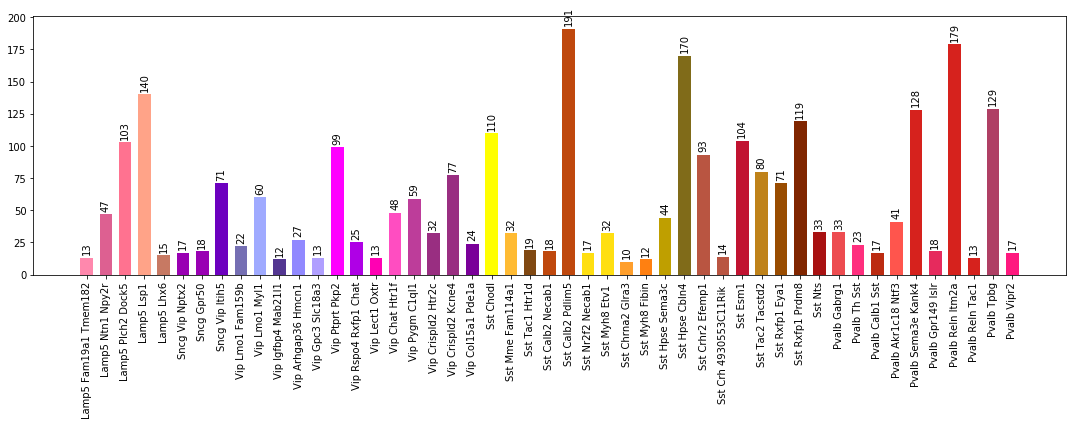

In [13]:
i = 0 
fig = plt.figure(figsize = (15,6))
ttype_list = []
for (ttype,col,xsort) in Y:
    ttype_list.append(ttype)
    counts = np.sum(O['cluster']==ttype)
    plt.bar(x=xsort,height=counts,color=col)
    plt.text(xsort,counts+4,str(counts),rotation = 90,horizontalalignment='center')
    i = i+1
ax = plt.gca()           
ax.set_xticks(xarr)
ax.set_xticklabels(ttype_list, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Patchseq_dist_for_patchseq-types.png',dpi=300)

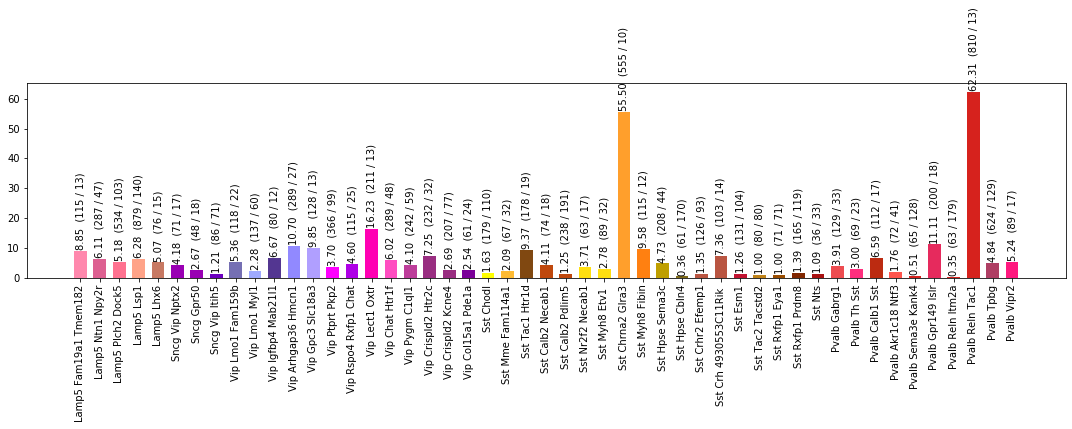

In [14]:
i = 0 
fig = plt.figure(figsize = (15,6))
ttype_list = []
df = []
for (ttype,col,xsort) in Y:
    ttype_list.append(ttype)
    ps_counts = np.sum(O['cluster']==ttype)
    facs_counts = np.sum(matdict['cluster']==ttype)
    count_ratio = float(facs_counts)/float(ps_counts)
    plt.bar(x=xsort,height=count_ratio,color=col)
    plt.text(xsort,count_ratio+1,'{:0.2f}  ({} / {})'.format(count_ratio,facs_counts,ps_counts),rotation = 90,horizontalalignment='center')
    i = i+1
    df.append((ttype,col,xsort,ps_counts,facs_counts,count_ratio))
ax = plt.gca()           
ax.set_xticks(xarr)
ax.set_xticklabels(ttype_list, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/FACS-to-PS_ratio_for_patchseq-types.png',dpi=300)

df = pd.DataFrame(df,columns=['ttype','col','x','ps_counts','facs_counts','facs_to_ps_ratio'])

T-types with significantly more Patchseq cells than there are FACS cells.
 - `Sst Hpse Cbln4`
 - `Pvalb Reln Itm2a`


In [15]:
df = df.sort_values(by=['x']).reset_index(drop=True)

In [17]:
df.sort_values(by=['facs_counts']).reset_index(drop=True)

,ttype,col,x,ps_counts,facs_counts,facs_to_ps_ratio
0,Sst Nts,#A81111,46.530612,33,36,1.090909
1,Sncg Gpr50,#9900B3,7.346939,18,48,2.666667
2,Vip Col15a1 Pde1a,#7A0099,24.489796,24,61,2.541667
3,Sst Hpse Cbln4,#806B19,37.959184,170,61,0.358824
4,Pvalb Reln Itm2a,#D6221D,55.102041,179,63,0.351955
5,Sst Nr2f2 Necab1,#FFDF11,31.836735,17,63,3.705882
6,Pvalb Sema3e Kank4,#D6221D,52.653061,128,65,0.507812
7,Sst Mme Fam114a1,#FFBB33,26.938776,32,67,2.093750
8,Pvalb Th Sst,#FF2F7E,48.979592,23,69,3.000000
9,Sncg Vip Nptx2,#9900B3,6.122449,17,71,4.176471


In [16]:
#Types with more patchseq cells than facs cells
df[df['facs_counts']<=df['ps_counts']]

,ttype,col,x,ps_counts,facs_counts,facs_to_ps_ratio
31,Sst Hpse Cbln4,#806B19,37.959184,170,61,0.358824
35,Sst Tac2 Tacstd2,#BF8219,42.857143,80,80,1.000000
36,Sst Rxfp1 Eya1,#994C00,44.081633,71,71,1.000000
43,Pvalb Sema3e Kank4,#D6221D,52.653061,128,65,0.507812
45,Pvalb Reln Itm2a,#D6221D,55.102041,179,63,0.351955


In [24]:
print('On average, FACS data has {:0.2f} times the # of cells compared to patchseq'.format(df['facs_to_ps_ratio'].mean()))

On average, FACS data has 6.75 times the # of cells compared to patchseq


In [25]:
#Types with more facs cells than the average scale up(down) factor:
df[df['facs_to_ps_ratio']>6.75]

,ttype,col,x,ps_counts,facs_counts,facs_to_ps_ratio
0,Lamp5 Fam19a1 Tmem182,#FF88AD,0.000000,13,115,8.846154
8,Pvalb Gpr149 Islr,#E62A5D,53.877551,18,200,11.111111
10,Pvalb Reln Tac1,#D6221D,56.326531,13,810,62.307692
21,Sst Chrna2 Glra3,#FF9F2C,34.285714,10,555,55.500000
22,Sst Crh 4930553C11Rik,#B95541,40.408163,14,103,7.357143
29,Sst Myh8 Fibin,#FF8011,35.510204,12,115,9.583333
34,Sst Tac1 Htr1d,#804811,28.163265,19,178,9.368421
36,Vip Arhgap36 Hmcn1,#9189FF,13.469388,27,289,10.703704
39,Vip Crispld2 Htr2c,#992E81,22.040816,32,232,7.250000
41,Vip Gpc3 Slc18a3,#B09FFF,14.693878,13,128,9.846154


In [26]:
df.sort_values(by=['facs_to_ps_ratio']).reset_index(drop=True)

,ttype,col,x,ps_counts,facs_counts,facs_to_ps_ratio
0,Pvalb Reln Itm2a,#D6221D,55.102041,179,63,0.351955
1,Sst Hpse Cbln4,#806B19,37.959184,170,61,0.358824
2,Pvalb Sema3e Kank4,#D6221D,52.653061,128,65,0.507812
3,Sst Rxfp1 Eya1,#994C00,44.081633,71,71,1.000000
4,Sst Tac2 Tacstd2,#BF8219,42.857143,80,80,1.000000
5,Sst Nts,#A81111,46.530612,33,36,1.090909
6,Sncg Vip Itih5,#6C00BF,8.571429,71,86,1.211268
7,Sst Calb2 Pdlim5,#BF480D,30.612245,191,238,1.246073
8,Sst Esm1,#C11331,41.632653,104,131,1.259615
9,Sst Crhr2 Efemp1,#B95541,39.183673,93,126,1.354839
